# Driver Identification using ResNet50 and GRU (RNN)
To better understand the code, check out `./prep_files/ResNet50_GRU_driverID.ipynb`. That notebook explains the thought process behind this code on a sample dataset whilst this goes straight to the point. 

Also the dataset used was different as that stored all data in memory while we plan on streaming from local storage as the dataset is 40+Gb

In [17]:
import numpy as np
import pandas as pd
import torch
from torchsummary import summary

from src.engine import ResNet50_GRU_engine
from src.model_driverID import ResNet50_GRU
from src.dataset import FeatureMapDataset
from src.hyperparam import RayTuning
from ray import tune, train

from IPython.display import display, HTML

# Load custom CSS file
css = HTML('<link rel="stylesheet" type="text/css" href="./custom.css">')  # Ensure the path is correct
display(css)

In [2]:
model = ResNet50_GRU()
summary(model, verbose=0)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─Bottleneck: 3-1              (75,008)
|    |    └─Bottleneck: 3-2              (70,400)
|    |    └─Bottleneck: 3-3              (70,400)
|    └─Sequential: 2-6                   --
|    |    └─Bottleneck: 3-4              (379,392)
|    |    └─Bottleneck: 3-5              (280,064)
|    |    └─Bottleneck: 3-6              (280,064)
|    |    └─Bottleneck: 3-7              (280,064)
|    └─Sequential: 2-7                   --
|    |    └─Bottleneck: 3-8              (1,512,448)
|    |    └─Bottleneck: 3-9              (1,117,184)
|    |    └─Bottleneck: 3-10             (1,117,184)
|    |    └─Bottleneck: 3-11             (1,117,184)
|    |    └─Bottleneck: 3

In [3]:
model

ResNet50_GRU(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2

In [4]:
from sklearn.utils.class_weight import compute_class_weight

import torch.nn as nn
import torch.optim as optim

#### Hyperparameter tuning of Model

In [5]:
y_train = pd.read_csv('./data/feature_maps_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values

class_weights = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights = class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

del y_train

----

In [5]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDataset(base_dir, mode='train')
val_test_datasets = FeatureMapDataset(base_dir, mode='valid')

In [6]:
from torch.utils.data import random_split

In [7]:
np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

In [8]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(46240, 5782, 5781)

In [9]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam"]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "scheduler": tune.choice(["exp"]),
    "gamma": tune.uniform(0.1, 0.9),
    "epochs": tune.choice([30]),
    "batch_size": tune.choice([32])
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRU
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [10]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [11]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=25)

(train_model pid=26652) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_aca60_00000/checkpoint_000000)
(train_model pid=26652) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_aca60_00000/checkpoint_000001)
(train_model pid=26652) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_aca60_00000/checkpoint_000002)
(train_model pid=26652) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Pr

Best trial config: {'optimizer': 'adam', 'lr': 0.0003872118032174588, 'scheduler': 'exp', 'gamma': 0.13618183112843046, 'epochs': 30, 'batch_size': 32}
Best trial final validation loss: 1.2275166817791554
Best trial final validation accuracy: 66.0325%
Test Accuracy: 0.6652828230409964
Best trial test set accuracy: 0.6653%


#### Model Training with given hyperparameters

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from src.engine import ResNet50_GRU_engine
from src.model_driverID import ResNet50_GRU
from src.dataset import FeatureMapDataset

In [18]:
np.random.seed(42)

batch_size = 64
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [19]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = ResNet50_GRU()
optimizer = optim.Adam(model.parameters(), lr=0.0003872118032174588)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.13618183112843046)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [20]:
engine = ResNet50_GRU_engine(model, optimizer, scheduler, criterion, device)

In [21]:
hist = engine.train_validation(train_dl, valid_dl, epochs=80, save_path='./model_checkpoint/run1_ResNet50_GRU_chkpt.pth')

np.save('./model_checkpoint/run1_ResNet50_GRU_history.npy', np.array(hist))

   Epoch [1/80], Train Loss: 1.2678, Train Accuracy: 57.42%, Val Loss: 1.2282, Val Accuracy: 61.29%
   Epoch [2/80], Train Loss: 1.1479, Train Accuracy: 62.15%, Val Loss: 1.2411, Val Accuracy: 61.36%
   Epoch [3/80], Train Loss: 1.1180, Train Accuracy: 63.18%, Val Loss: 1.2393, Val Accuracy: 63.80%
   Epoch [4/80], Train Loss: 1.1100, Train Accuracy: 63.23%, Val Loss: 1.2486, Val Accuracy: 62.14%
   Epoch [5/80], Train Loss: 1.1102, Train Accuracy: 63.01%, Val Loss: 1.2521, Val Accuracy: 63.59%
   Epoch [6/80], Train Loss: 1.1133, Train Accuracy: 63.11%, Val Loss: 1.2504, Val Accuracy: 63.71%
   Epoch [7/80], Train Loss: 1.1133, Train Accuracy: 63.41%, Val Loss: 1.2387, Val Accuracy: 61.90%
   Epoch [8/80], Train Loss: 1.1061, Train Accuracy: 63.30%, Val Loss: 1.2612, Val Accuracy: 64.56%
   Epoch [9/80], Train Loss: 1.1130, Train Accuracy: 63.25%, Val Loss: 1.2463, Val Accuracy: 62.95%
   Epoch [10/80], Train Loss: 1.1198, Train Accuracy: 62.92%, Val Loss: 1.2456, Val Accuracy: 63.59%

Plotting history

In [22]:
from src.plot import plot_history

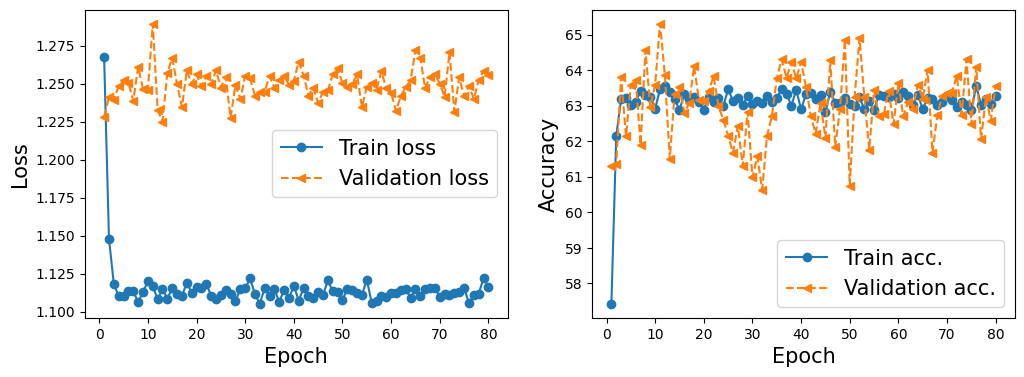

In [23]:
plot_history(hist)

## 2nd Run with Hyperparam Optimization and Model training.
Decided to rescale my images to [0, 1] and normalize it to the mean and std of ImageNet data used in training the pretrained ResNet50 model. This was done in accordance to the advice on the documentation. Hopefully, we would observe an improved performance.

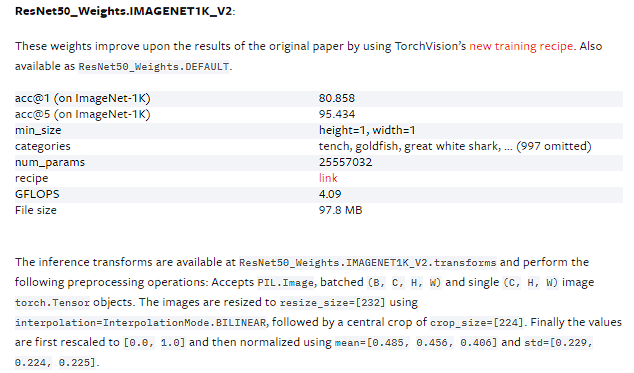

In [10]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-6, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10, 15]),  # for ReduceLROnPlateau
    "epochs": tune.choice([40]),
    "batch_size": tune.choice([32, 64]),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2, 3]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRU
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [11]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [12]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

(train_model pid=26796) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_ebc70_00000/checkpoint_000000)
(train_model pid=26796) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_ebc70_00000/checkpoint_000001)
(train_model pid=26796) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_ebc70_00000/checkpoint_000002)
(train_model pid=26796) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Pr

----

## 3rd Run: Comparing if the rescaling and normalization positively affects performance

W/out rescaling and normalizing:

In [28]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDataset(base_dir, mode='train', rescale=False)
val_test_datasets = FeatureMapDataset(base_dir, mode='valid', rescale=False)

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset

from src.engine import ResNet50_GRU_engine
from src.model_driverID import ResNet50_GRU
from src.dataset import FeatureMapDataset
from src.plot import plot_history

In [30]:
np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

In [31]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(46240, 5782, 5781)

In [32]:
import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

In [33]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(4624, 578, 578)

In [34]:
np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [35]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = ResNet50_GRU(hidden_size=1024, num_layers=1, dropout=0.7)
optimizer = optim.Adam(model.parameters(), lr=0.0003872118032174588, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.13618183112843046)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

c:\Users\LEGION\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [36]:
engine = ResNet50_GRU_engine(model, optimizer, scheduler, criterion, device)

In [37]:
hist = engine.train_validation(train_dl, valid_dl, epochs=10, save_path=None)

   Epoch [1/10], Train Loss: 1.3344, Train Accuracy: 56.29%, Val Loss: 1.5098, Val Accuracy: 61.76%
   Epoch [2/10], Train Loss: 1.0926, Train Accuracy: 64.92%, Val Loss: 1.2665, Val Accuracy: 62.80%
   Epoch [3/10], Train Loss: 0.9883, Train Accuracy: 66.93%, Val Loss: 1.2530, Val Accuracy: 62.98%
   Epoch [4/10], Train Loss: 1.0124, Train Accuracy: 65.61%, Val Loss: 1.4103, Val Accuracy: 63.32%
   Epoch [5/10], Train Loss: 0.9993, Train Accuracy: 66.09%, Val Loss: 1.4351, Val Accuracy: 63.15%
   Epoch [6/10], Train Loss: 0.9955, Train Accuracy: 66.57%, Val Loss: 1.3304, Val Accuracy: 63.49%
   Epoch [7/10], Train Loss: 0.9988, Train Accuracy: 67.37%, Val Loss: 1.4007, Val Accuracy: 61.07%
   Epoch [8/10], Train Loss: 0.9983, Train Accuracy: 67.30%, Val Loss: 1.3309, Val Accuracy: 62.46%
   Epoch [9/10], Train Loss: 1.0120, Train Accuracy: 66.70%, Val Loss: 1.3755, Val Accuracy: 61.25%
   Epoch [10/10], Train Loss: 1.0147, Train Accuracy: 67.06%, Val Loss: 1.3480, Val Accuracy: 60.38%

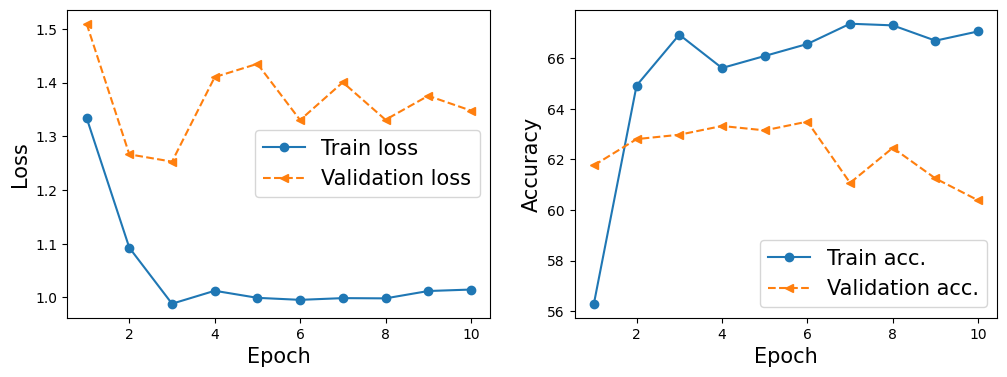

In [38]:
# after unfreezing layer4
plot_history(hist)

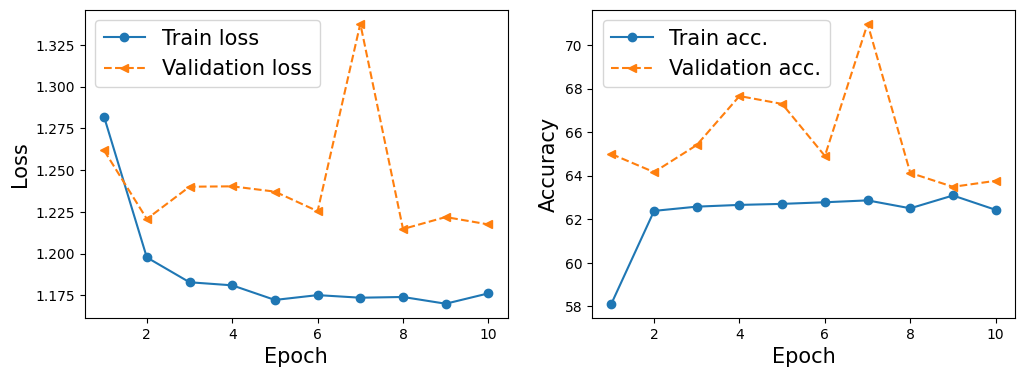

In [50]:
plot_history(a)  ## to cause an error because I don't want to run this
plot_history(hist)

With rescaling and normalizing

In [6]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDataset(base_dir, mode='train', rescale=True)
val_test_datasets = FeatureMapDataset(base_dir, mode='valid', rescale=True)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset

from src.engine import ResNet50_GRU_engine
from src.model_driverID import ResNet50_GRU
from src.dataset import FeatureMapDataset
from src.plot import plot_history

In [8]:
np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

In [9]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(46240, 5782, 5781)

In [10]:
import random
np.random.seed(42)

train_datasets = Subset(train_datasets, random.sample(range(46240), 5000))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 600))
test_datasets = Subset(test_datasets, random.sample(range(5781), 600))

In [11]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(5000, 600, 600)

In [12]:
np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [13]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = ResNet50_GRU(hidden_size=1024, num_layers=1, dropout=0.7)
optimizer = optim.Adam(model.parameters(), lr=0.0003872118032174588, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.13618183112843046)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

c:\Users\LEGION\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [47]:
engine = ResNet50_GRU_engine(model, optimizer, scheduler, criterion, device)

In [48]:
hist = engine.train_validation(train_dl, valid_dl, epochs=10, save_path=None)

   Epoch [1/10], Train Loss: 1.4083, Train Accuracy: 48.81%, Val Loss: 1.5123, Val Accuracy: 63.67%
   Epoch [2/10], Train Loss: 1.0742, Train Accuracy: 61.66%, Val Loss: 1.4571, Val Accuracy: 63.32%
   Epoch [3/10], Train Loss: 0.9577, Train Accuracy: 65.29%, Val Loss: 1.3510, Val Accuracy: 63.15%
   Epoch [4/10], Train Loss: 0.9699, Train Accuracy: 65.64%, Val Loss: 1.3442, Val Accuracy: 62.98%
   Epoch [5/10], Train Loss: 0.9326, Train Accuracy: 65.72%, Val Loss: 1.3537, Val Accuracy: 61.94%
   Epoch [6/10], Train Loss: 0.9390, Train Accuracy: 64.84%, Val Loss: 1.3275, Val Accuracy: 62.11%
   Epoch [7/10], Train Loss: 0.9570, Train Accuracy: 65.07%, Val Loss: 1.3796, Val Accuracy: 64.01%
   Epoch [8/10], Train Loss: 0.9587, Train Accuracy: 64.97%, Val Loss: 1.2741, Val Accuracy: 62.98%
   Epoch [9/10], Train Loss: 0.9548, Train Accuracy: 65.68%, Val Loss: 1.4196, Val Accuracy: 63.84%
   Epoch [10/10], Train Loss: 0.9356, Train Accuracy: 66.07%, Val Loss: 1.4349, Val Accuracy: 62.98%

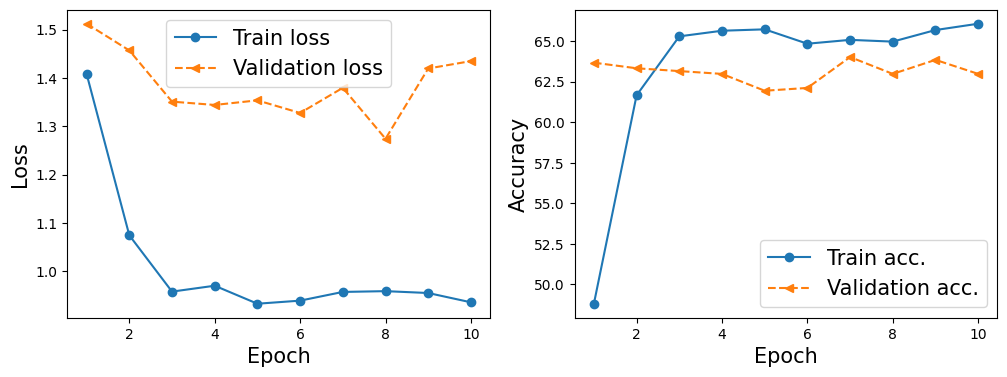

In [49]:
# after unfreezing layer4
plot_history(hist)

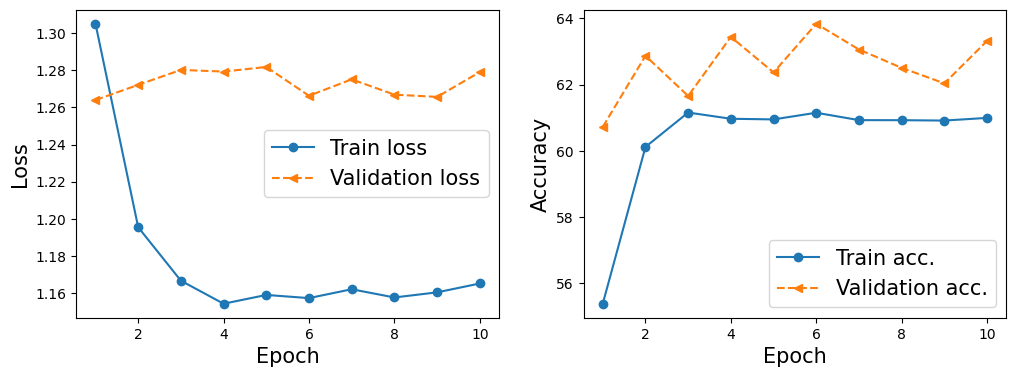

In [60]:
plot_history(a)  ## to cause an error because I don't want to run this
plot_history(hist)

Mega-Hyper Param Tuning (trying out different model configs)

In [14]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [15]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [16]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [18]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

(train_model pid=18496) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_9aec4_00000/checkpoint_000000)
(train_model pid=18496) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_9aec4_00000/checkpoint_000001)
(train_model pid=18496) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_9aec4_00000/checkpoint_000002)
(train_model pid=18496) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Pr

Best trial config: {'optimizer': 'adam', 'lr': 0.0015930522616241034, 'scheduler': 'ReduceLROnPlateau', 'gamma': 0.6207107783590823, 'patience': 5, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.008706020878304863, 'hidden_size': 512, 'num_layers': 2, 'dropout': 0.30031150633640574}
Best trial final validation loss: 1.2549992329195927
Best trial final validation accuracy: 66.5000%
Test Accuracy: 0.6483333333333333
Best trial test set accuracy: 0.6483%


Unfreeze Layer 3 and 4

In [19]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True
            for param in self.resnet50.layer3.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [20]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [21]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [22]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

(train_model pid=25244) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_f6201_00000/checkpoint_000000)
(train_model pid=25244) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_f6201_00000/checkpoint_000001)
(train_model pid=25244) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_f6201_00000/checkpoint_000002)
(train_model pid=25244) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Pr

2024-07-27 06:15:13,089	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0400s.
2024-07-27 06:15:13,109	INFO tune.py:1041 -- Total run time: 7404.98 seconds (7404.78 seconds for the tuning loop).


Best trial config: {'optimizer': 'adamw', 'lr': 0.0012057860169848373, 'scheduler': 'exp', 'gamma': 0.2106824739342411, 'patience': 5, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.00018428536387181372, 'hidden_size': 512, 'num_layers': 2, 'dropout': 0.5858380416719808}
Best trial final validation loss: 1.237882325523778
Best trial final validation accuracy: 61.3333%
Test Accuracy: 0.6183333333333333
Best trial test set accuracy: 0.6183%


### Doing the same but for non-rescaled data

In [23]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDataset(base_dir, mode='train', rescale=False)
val_test_datasets = FeatureMapDataset(base_dir, mode='valid', rescale=False)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [24]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [25]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [26]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [27]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-27 08:19:36,114	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0400s.
2024-07-27 08:19:36,134	INFO tune.py:1041 -- Total run time: 7446.73 seconds (7446.65 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.0018735497784242818, 'scheduler': 'ReduceLROnPlateau', 'gamma': 0.2951917147032669, 'patience': 10, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.009073727166787792, 'hidden_size': 1024, 'num_layers': 2, 'dropout': 0.6624395150874216}
Best trial final validation loss: 1.1086478201966536
Best trial final validation accuracy: 76.6436%
Test Accuracy: 0.6868512110726643
Best trial test set accuracy: 0.6869%


Unfreeze Layer 3 and 4

In [28]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True
            for param in self.resnet50.layer3.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [29]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [30]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [31]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-27 10:15:57,552	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0385s.
2024-07-27 10:15:57,577	INFO tune.py:1041 -- Total run time: 6965.02 seconds (6964.95 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.001723882927632851, 'scheduler': 'exp', 'gamma': 0.1569509187681832, 'patience': 5, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.00043446146328325055, 'hidden_size': 512, 'num_layers': 2, 'dropout': 0.30930877429433035}
Best trial final validation loss: 1.056163004060325
Best trial final validation accuracy: 73.5294%
Test Accuracy: 0.7006920415224913
Best trial test set accuracy: 0.7007%


### Back to scaled data but this time adding noise

In [58]:
from dataset import FeatureMapDatasetALL

In [59]:
# Test code to verify shapes
dataset = FeatureMapDatasetALL(base_dir='./data/feature_maps_labels/', mode='train', rescale=True, augment=True)
for i in range(5):
    feature_map, label = dataset[i]
    print(feature_map.shape)  # Should consistently print torch.Size([3, 224, 224])


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [60]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetALL(base_dir, mode='train', rescale=True, augment=True)
val_test_datasets = FeatureMapDatasetALL(base_dir, mode='valid', rescale=True, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [61]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [62]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [63]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [64]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-27 12:11:03,654	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0400s.
2024-07-27 12:11:03,694	INFO tune.py:1041 -- Total run time: 4764.05 seconds (4763.94 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.003918194347141745, 'scheduler': 'exp', 'gamma': 0.685595153449124, 'patience': 5, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.0015620693675639887, 'hidden_size': 512, 'num_layers': 1, 'dropout': 0.33998996632720113}
Best trial final validation loss: 1.1598155639673535
Best trial final validation accuracy: 68.5121%
Test Accuracy: 0.726643598615917
Best trial test set accuracy: 0.7266%


In [65]:
from dataset import FeatureMapDatasetNORoT

In [66]:
# Test code to verify shapes
dataset = FeatureMapDatasetNORoT(base_dir='./data/feature_maps_labels/', mode='train', rescale=True, augment=True)
for i in range(5):
    feature_map, label = dataset[i]
    print(feature_map.shape)  # Should consistently print torch.Size([3, 224, 224])


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [67]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetNORoT(base_dir, mode='train', rescale=True, augment=True)
val_test_datasets = FeatureMapDatasetNORoT(base_dir, mode='valid', rescale=True, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [68]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [69]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [70]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [71]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-27 13:52:07,829	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0400s.
2024-07-27 13:52:07,869	INFO tune.py:1041 -- Total run time: 6050.92 seconds (6050.81 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.0013260331922696565, 'scheduler': 'exp', 'gamma': 0.3048546582090592, 'patience': 5, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.0011103647313054636, 'hidden_size': 1024, 'num_layers': 2, 'dropout': 0.3101676506976381}
Best trial final validation loss: 1.159677753323003
Best trial final validation accuracy: 66.7820%
Test Accuracy: 0.6626297577854672
Best trial test set accuracy: 0.6626%


In [72]:
from dataset import FeatureMapDatasetJITTER

In [73]:
# Test code to verify shapes
dataset = FeatureMapDatasetJITTER(base_dir='./data/feature_maps_labels/', mode='train', rescale=True, augment=True)


In [74]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetJITTER(base_dir, mode='train', rescale=True, augment=True)
val_test_datasets = FeatureMapDatasetJITTER(base_dir, mode='valid', rescale=True, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [75]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [76]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [77]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [78]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-27 15:12:24,397	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0608s.
2024-07-27 15:12:24,423	INFO tune.py:1041 -- Total run time: 4803.55 seconds (4803.45 seconds for the tuning loop).


Best trial config: {'optimizer': 'adamw', 'lr': 0.00027810936979265577, 'scheduler': 'exp', 'gamma': 0.3155298670388172, 'patience': 10, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.0076881068014749586, 'hidden_size': 512, 'num_layers': 2, 'dropout': 0.5075162486973464}
Best trial final validation loss: 1.1128551630597365
Best trial final validation accuracy: 65.0519%
Test Accuracy: 0.6557093425605537
Best trial test set accuracy: 0.6557%


### Doing the same but for unfrozen layer 3 and layer 4

In [79]:
from dataset import FeatureMapDatasetALL

In [80]:
# Test code to verify shapes
dataset = FeatureMapDatasetALL(base_dir='./data/feature_maps_labels/', mode='train', rescale=True, augment=True)


In [81]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetALL(base_dir, mode='train', rescale=True, augment=True)
val_test_datasets = FeatureMapDatasetALL(base_dir, mode='valid', rescale=True, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [82]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            for param in self.resnet50.layer3.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [83]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [84]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [85]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-27 17:02:32,409	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0394s.
2024-07-27 17:02:32,450	INFO tune.py:1041 -- Total run time: 6596.73 seconds (6596.62 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.00040596116104843125, 'scheduler': 'ReduceLROnPlateau', 'gamma': 0.10565304417577392, 'patience': 5, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.00038234752246751907, 'hidden_size': 1024, 'num_layers': 1, 'dropout': 0.3557975442608167}
Best trial final validation loss: 1.0937034126959349
Best trial final validation accuracy: 65.0519%
Test Accuracy: 0.6470588235294118
Best trial test set accuracy: 0.6471%


In [86]:
from dataset import FeatureMapDatasetNORoT

In [87]:
# Test code to verify shapes
dataset = FeatureMapDatasetNORoT(base_dir='./data/feature_maps_labels/', mode='train', rescale=True, augment=True)
for i in range(5):
    feature_map, label = dataset[i]
    print(feature_map.shape)  # Should consistently print torch.Size([3, 224, 224])


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [88]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetNORoT(base_dir, mode='train', rescale=True, augment=True)
val_test_datasets = FeatureMapDatasetNORoT(base_dir, mode='valid', rescale=True, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [89]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [90]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [91]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [92]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-27 18:29:21,806	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0424s.
2024-07-27 18:29:21,845	INFO tune.py:1041 -- Total run time: 5196.46 seconds (5196.35 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.0015930522616241034, 'scheduler': 'ReduceLROnPlateau', 'gamma': 0.6207107783590823, 'patience': 5, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.008706020878304863, 'hidden_size': 512, 'num_layers': 2, 'dropout': 0.30031150633640574}
Best trial final validation loss: 1.1569871996578418
Best trial final validation accuracy: 71.7993%
Test Accuracy: 0.7093425605536332
Best trial test set accuracy: 0.7093%


In [93]:
from dataset import FeatureMapDatasetJITTER

In [94]:
# Test code to verify shapes
dataset = FeatureMapDatasetJITTER(base_dir='./data/feature_maps_labels/', mode='train', rescale=True, augment=True)


In [95]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetJITTER(base_dir, mode='train', rescale=True, augment=True)
val_test_datasets = FeatureMapDatasetJITTER(base_dir, mode='valid', rescale=True, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [96]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [97]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [98]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [99]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-27 19:59:31,858	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0300s.
2024-07-27 19:59:31,898	INFO tune.py:1041 -- Total run time: 5398.02 seconds (5397.91 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.00014063366777718192, 'scheduler': 'exp', 'gamma': 0.6208616204015556, 'patience': 10, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.005323617594751501, 'hidden_size': 512, 'num_layers': 1, 'dropout': 0.32542334011440943}
Best trial final validation loss: 1.2266135184388411
Best trial final validation accuracy: 64.8789%
Test Accuracy: 0.6833910034602076
Best trial test set accuracy: 0.6834%


### Now performing Data Augmentations on Non-scaled data

In [100]:
from dataset import FeatureMapDatasetALL

In [101]:
# Test code to verify shapes
dataset = FeatureMapDatasetALL(base_dir='./data/feature_maps_labels/', mode='train', rescale=False, augment=True)
for i in range(5):
    feature_map, label = dataset[i]
    print(feature_map.shape)  # Should consistently print torch.Size([3, 224, 224])


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [102]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetALL(base_dir, mode='train', rescale=False, augment=True)
val_test_datasets = FeatureMapDatasetALL(base_dir, mode='valid', rescale=False, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [103]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [104]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [105]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [106]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-27 21:08:02,756	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0376s.
2024-07-27 21:08:02,798	INFO tune.py:1041 -- Total run time: 4098.56 seconds (4098.44 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.0013260331922696565, 'scheduler': 'exp', 'gamma': 0.3048546582090592, 'patience': 5, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.0011103647313054636, 'hidden_size': 1024, 'num_layers': 2, 'dropout': 0.3101676506976381}
Best trial final validation loss: 1.1417741426511814
Best trial final validation accuracy: 69.7232%
Test Accuracy: 0.6885813148788927
Best trial test set accuracy: 0.6886%


In [107]:
from dataset import FeatureMapDatasetNORoT

In [108]:
# Test code to verify shapes
dataset = FeatureMapDatasetNORoT(base_dir='./data/feature_maps_labels/', mode='train', rescale=False, augment=True)
for i in range(5):
    feature_map, label = dataset[i]
    print(feature_map.shape)  # Should consistently print torch.Size([3, 224, 224])


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [109]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetNORoT(base_dir, mode='train', rescale=False, augment=True)
val_test_datasets = FeatureMapDatasetNORoT(base_dir, mode='valid', rescale=False, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [110]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [111]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [112]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [113]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-27 22:38:10,408	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0399s.
2024-07-27 22:38:10,451	INFO tune.py:1041 -- Total run time: 5392.98 seconds (5392.87 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.00014063366777718192, 'scheduler': 'exp', 'gamma': 0.6208616204015556, 'patience': 10, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.005323617594751501, 'hidden_size': 512, 'num_layers': 1, 'dropout': 0.32542334011440943}
Best trial final validation loss: 1.138977269593038
Best trial final validation accuracy: 74.0484%
Test Accuracy: 0.745674740484429
Best trial test set accuracy: 0.7457%


In [114]:
from dataset import FeatureMapDatasetJITTER

In [115]:
# Test code to verify shapes
dataset = FeatureMapDatasetJITTER(base_dir='./data/feature_maps_labels/', mode='train', rescale=False, augment=True)


In [116]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetJITTER(base_dir, mode='train', rescale=False, augment=True)
val_test_datasets = FeatureMapDatasetJITTER(base_dir, mode='valid', rescale=False, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [117]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [118]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [119]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [120]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-27 23:48:51,469	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0403s.
2024-07-27 23:48:51,534	INFO tune.py:1041 -- Total run time: 4228.20 seconds (4228.06 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.006187670675880951, 'scheduler': 'exp', 'gamma': 0.3514847848610614, 'patience': 10, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.0024605498767271776, 'hidden_size': 256, 'num_layers': 1, 'dropout': 0.5417669517111269}
Best trial final validation loss: 1.115259023089158
Best trial final validation accuracy: 73.5294%
Test Accuracy: 0.6868512110726643
Best trial test set accuracy: 0.6869%


### Doing the same but for unfrozen layer 3 and layer 4

In [121]:
from dataset import FeatureMapDatasetALL

In [122]:
# Test code to verify shapes
dataset = FeatureMapDatasetALL(base_dir='./data/feature_maps_labels/', mode='train', rescale=False, augment=True)


In [123]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetALL(base_dir, mode='train', rescale=False, augment=True)
val_test_datasets = FeatureMapDatasetALL(base_dir, mode='valid', rescale=False, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [124]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            for param in self.resnet50.layer3.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [125]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [126]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [127]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-28 01:26:06,133	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0419s.
2024-07-28 01:26:06,178	INFO tune.py:1041 -- Total run time: 5822.27 seconds (5822.16 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.00040596116104843125, 'scheduler': 'ReduceLROnPlateau', 'gamma': 0.10565304417577392, 'patience': 5, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.00038234752246751907, 'hidden_size': 1024, 'num_layers': 1, 'dropout': 0.3557975442608167}
Best trial final validation loss: 1.119341956941705
Best trial final validation accuracy: 65.0519%
Test Accuracy: 0.6141868512110726
Best trial test set accuracy: 0.6142%


In [128]:
from dataset import FeatureMapDatasetNORoT

In [129]:
# Test code to verify shapes
dataset = FeatureMapDatasetNORoT(base_dir='./data/feature_maps_labels/', mode='train', rescale=False, augment=True)
for i in range(5):
    feature_map, label = dataset[i]
    print(feature_map.shape)  # Should consistently print torch.Size([3, 224, 224])


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [130]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetNORoT(base_dir, mode='train', rescale=False, augment=True)
val_test_datasets = FeatureMapDatasetNORoT(base_dir, mode='valid', rescale=False, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [131]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [132]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [133]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [134]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-28 03:02:25,273	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0391s.
2024-07-28 03:02:25,308	INFO tune.py:1041 -- Total run time: 5765.23 seconds (5765.13 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.001519798062003424, 'scheduler': 'exp', 'gamma': 0.27619283805243866, 'patience': 10, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.0010572705046816898, 'hidden_size': 1024, 'num_layers': 2, 'dropout': 0.5580691161637799}
Best trial final validation loss: 1.0362114716125161
Best trial final validation accuracy: 70.2422%
Test Accuracy: 0.6401384083044983
Best trial test set accuracy: 0.6401%


In [135]:
from dataset import FeatureMapDatasetJITTER

In [136]:
# Test code to verify shapes
dataset = FeatureMapDatasetJITTER(base_dir='./data/feature_maps_labels/', mode='train', rescale=False, augment=True)


In [137]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDatasetJITTER(base_dir, mode='train', rescale=False, augment=True)
val_test_datasets = FeatureMapDatasetJITTER(base_dir, mode='valid', rescale=False, augment=True)

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

np.random.seed(42)

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [138]:
import torch
import torch.nn as nn
from torchvision import models


## Single Task model for driver identification. Multiclass classification (Not_driving, Driver1, Driver2)
## `Nor_driving` class is more like a dummy label which represents data that's not associated with any driver or even driving at all 

class ResNet50_GRUX(nn.Module):
      def __init__(self, hidden_size=512, num_classes=4, num_layers=2, dropout=0.5):
            super(ResNet50_GRUX, self).__init__()

            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Optionally unfreeze some of the last layers
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True
            for param in self.resnet50.layer4.parameters():
                  param.requires_grad = True

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(dropout)

            # Define a GRU layer
            if num_layers==1:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            else:
                  self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(batch_size, 7*7, 2048)
            
            gru_out, _ = self.gru(features)
            gru_out = gru_out[:, -1, :]
            
            out = self.fc(gru_out)
            
            return out


In [139]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.1, 0.9),  # for exponential scheduler
    "patience": tune.choice([5, 10]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),
    "batch_size": tune.choice([32]),
    "weight_decay": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([256, 512, 1024]),
    "num_layers": tune.choice([1, 2]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7)  # Dropout rate
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRUX
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [140]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [141]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

2024-07-28 04:39:41,465	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU' in 0.0408s.
2024-07-28 04:39:41,499	INFO tune.py:1041 -- Total run time: 5822.88 seconds (5822.79 seconds for the tuning loop).


Best trial config: {'optimizer': 'adam', 'lr': 0.0007027534096484151, 'scheduler': 'exp', 'gamma': 0.2589725452273379, 'patience': 10, 'epochs': 20, 'batch_size': 32, 'weight_decay': 0.00010669882710369729, 'hidden_size': 1024, 'num_layers': 1, 'dropout': 0.58453678109946}
Best trial final validation loss: 1.0266241878271103
Best trial final validation accuracy: 71.6263%
Test Accuracy: 0.7214532871972318
Best trial test set accuracy: 0.7215%


## Now performing Data Augmentations on Non-scaled data

### Applying data augmentation on Non-scaled Data